In [123]:
import keras.layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

In [124]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

In [125]:
print(train_data.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [126]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [127]:
print(train_data.shape, train_labels.shape)

(54000, 28, 28) (54000,)


label = 7


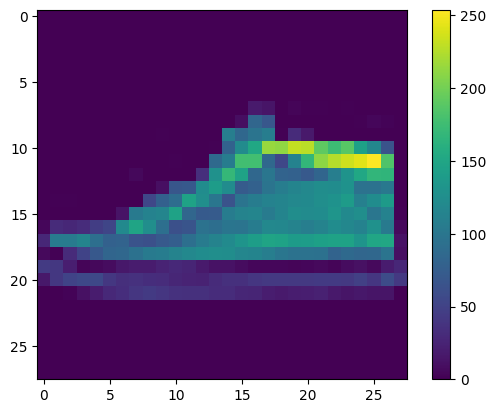

In [128]:
index = 5901
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [129]:
train_data = train_data / 255
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)

In [130]:
def one_hot_label(image, label):
    label = tf.one_hot(label, depth=10)
    return image, label

In [131]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data,valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [132]:
model = keras.Sequential([

    keras.layers.Reshape(input_shape=(28, 28), target_shape=(28, 28, 1)),

    keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(200, kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Activation('relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10,kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.Activation('softmax')
])

In [133]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              #모델 아웃풋이 logiist인 상태 자체적으로 로짓과 액티베이션을 분리해서 다양한 액티베이션으로 분석함

              metrics=['accuracy'])


In [134]:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.02510968 0.46406204 0.07627092 0.06027238 0.03861941 0.0029964
  0.02241093 0.11880577 0.09497601 0.0964764 ]]


In [135]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 64)       

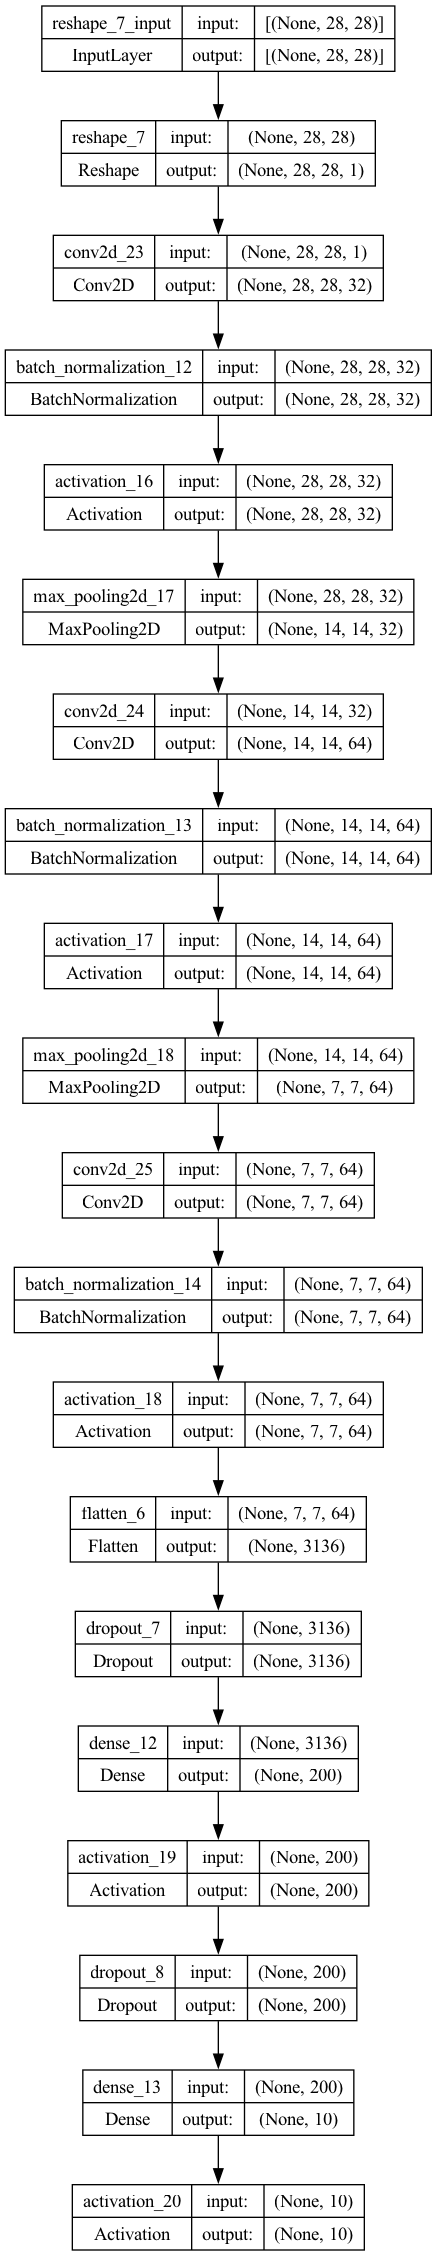

In [136]:

tf.keras.utils.plot_model(model, show_shapes=True)

In [137]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5',
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [ ]:
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[check_point_cb, early_stopping_cb]
                    )

Epoch 1/100


/Users/soma/anaconda3/envs/tensor2/lib/python3.9/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-26 14:52:11.237975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1686/1687 [============================>.] - ETA: 0s - loss: 0.5610 - accuracy: 0.8010

2023-12-26 14:52:57.445043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.35698, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 49s 28ms/step - loss: 0.5610 - accuracy: 0.8011 - val_loss: 0.3570 - val_accuracy: 0.8713
Epoch 2/100
1685/1687 [============================>.] - ETA: 0s - loss: 0.3584 - accuracy: 0.8693
Epoch 2: val_loss improved from 0.35698 to 0.31505, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 36s 21ms/step - loss: 0.3583 - accuracy: 0.8693 - val_loss: 0.3151 - val_accuracy: 0.8889
Epoch 3/100
1687/1687 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8869
Epoch 3: val_loss improved from 0.31505 to 0.29142, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 35s 21ms/step - loss: 0.3126 - accuracy: 0.8869 - val_loss: 0.2914 - val_accuracy: 0.8915
Epoch 4/100
1687/1687 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8984
Epoch 4: val_loss improved f

In [ ]:
# 코드 수정
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [ ]:
results = model.evaluate(test_dataset)